In [ ]:
import kagglehub
bhaveshmittal_melanoma_cancer_dataset_path = kagglehub.dataset_download('bhaveshmittal/melanoma-cancer-dataset')

print('Data source import complete.')


In [ ]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Dataset directories
BASE_DIR = "/kaggle/input/melanoma-cancer-dataset/"  # Change based on your dataset location
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")

# Image size and batch size
IMG_SIZE = (224, 224)  # Optimal size for EfficientNetB0
BATCH_SIZE = 32

# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Rescaling only for Testing
test_datagen = ImageDataGenerator(rescale=1./255)

# Load Training Data
train_generator = train_datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"  # Binary classification: Benign vs Malignant
)

# Load Testing Data
test_generator = test_datagen.flow_from_directory(
    directory=TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

# Print class labels
print("Class Mapping:", train_generator.class_indices)

Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Class Mapping: {'Benign': 0, 'Malignant': 1}


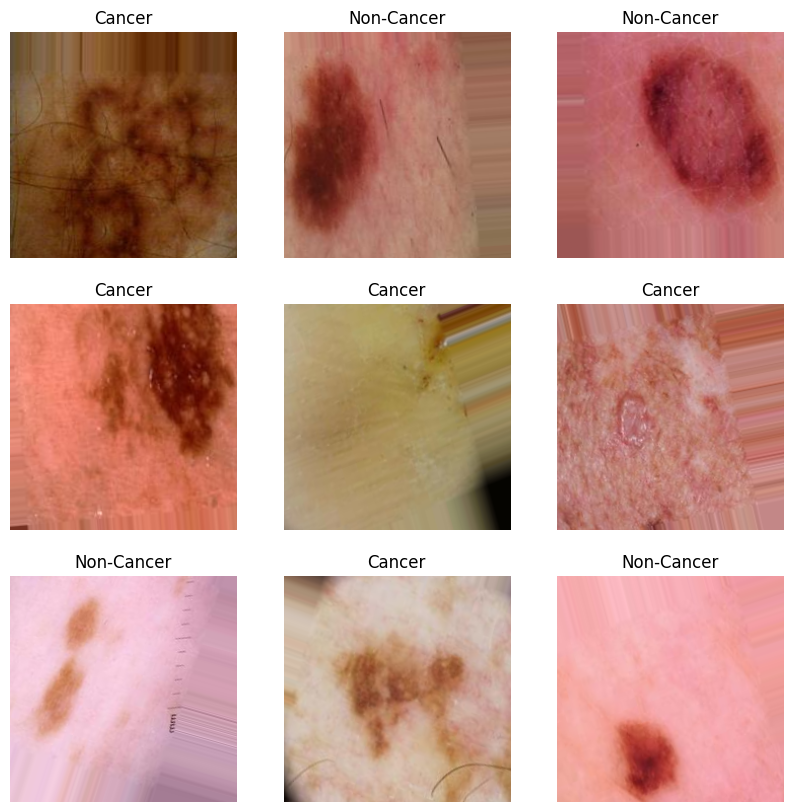

In [ ]:
# Display some sample images from dataset
def plot_images(generator):
    images, labels = next(generator)  # Get a batch
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title("Cancer" if labels[i] == 1 else "Non-Cancer")
        plt.axis("off")
    plt.show()

# Plot Training Images
plot_images(train_generator)

In [ ]:
from tensorflow.keras import layers, models

# Build the CNN model
model = models.Sequential([
    # 1st Convolution Block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),

    # 2nd Convolution Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # 3rd Convolution Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flattening Layer
    layers.Flatten(),

    # Fully Connected Layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout to reduce overfitting
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam',  # Optimizer for faster convergence
              loss='binary_crossentropy',  # Binary classification loss
              metrics=['accuracy'])  # Accuracy metric

# Model Summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,396,609 (169.36 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# EarlyStopping to stop training when the model stops improving
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,  # Stop training after 5 epochs with no improvement
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau to reduce the learning rate if the model stops improving
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,  # Reduce LR if no improvement after 3 epochs
    min_lr=1e-7,
    verbose=1
)


history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=20,  # Set number of epochs to train the model
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


371/371 ━━━━━━━━━━━━━━━━━━━━ 863s 2s/step - accuracy: 0.7035 - loss: 0.6578 - val_accuracy: 0.6623 - val_loss: 0.5531 - learning_rate: 0.0010
Epoch 2/20
  1/371 ━━━━━━━━━━━━━━━━━━━━ 12:08 2s/step - accuracy: 0.8438 - loss: 0.4487

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 932us/step - accuracy: 0.8438 - loss: 0.4487 - val_accuracy: 0.6875 - val_loss: 0.4304 - learning_rate: 0.0010
Epoch 3/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 851s 2s/step - accuracy: 0.8163 - loss: 0.4113 - val_accuracy: 0.8448 - val_loss: 0.3804 - learning_rate: 0.0010
Epoch 4/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.7500 - loss: 0.5150 - val_accuracy: 0.9375 - val_loss: 0.2618 - learning_rate: 0.0010
Epoch 5/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 844s 2s/step - accuracy: 0.8176 - loss: 0.4052 - val_accuracy: 0.8009 - val_loss: 0.4281 - learning_rate: 0.0010
Epoch 6/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 693us/step - accuracy: 0.8750 - loss: 0.3545 - val_accuracy: 0.6250 - val_loss: 0.6993 - learning_rate: 0.0010
Epoch 7/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8283 - loss: 0.3987
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
371/371 ━━━━━━━━━━━━━━━━━━━━ 838s 2s/step - accuracy: 0.8283 - loss: 0.3986 - val_a

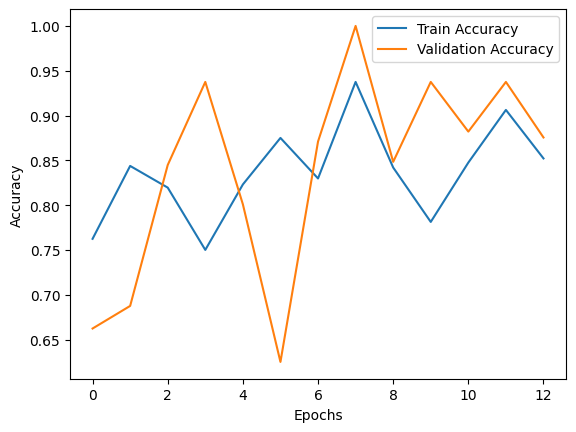

In [ ]:

# Save Model
model.save("skin_cancer_cnn.h5")

# Plot Training History
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

62/62 ━━━━━━━━━━━━━━━━━━━━ 33s 537ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.55      0.53      1000
           1       0.51      0.47      0.49       984

    accuracy                           0.51      1984
   macro avg       0.51      0.51      0.51      1984
weighted avg       0.51      0.51      0.51      1984



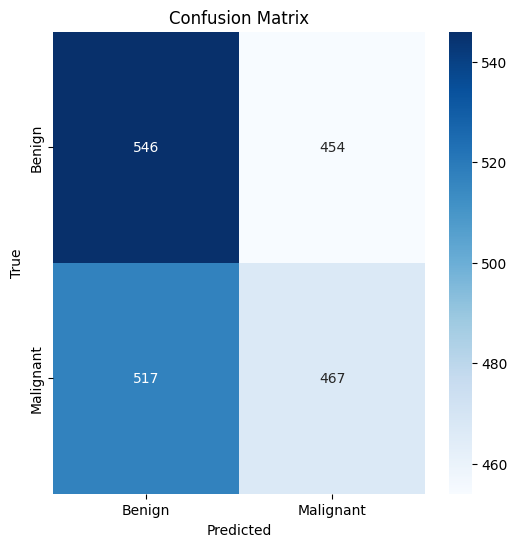

In [ ]:
# Predict on the test set
test_pred = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=1)

# Convert predictions to binary labels (0 or 1)
test_pred_labels = (test_pred > 0.5).astype("int32")

# Get the true labels
test_true_labels = test_generator.classes[:len(test_pred_labels)]  # Match length to predictions

# Classification report
print("Classification Report:")
print(classification_report(test_true_labels, test_pred_labels))

# Confusion Matrix
cm = confusion_matrix(test_true_labels, test_pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the entire model
model = load_model('/kaggle/working/skin_cancer_cnn.h5')


def predict_skin_cancer(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))  # Load Image
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make Prediction
    prediction = model.predict(img_array)
    class_label = "Malignant" if prediction > 0.5 else "Benign"

    # Show Image with Prediction
    plt.imshow(img)
    plt.title(f"Predicted: {class_label}")
    plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


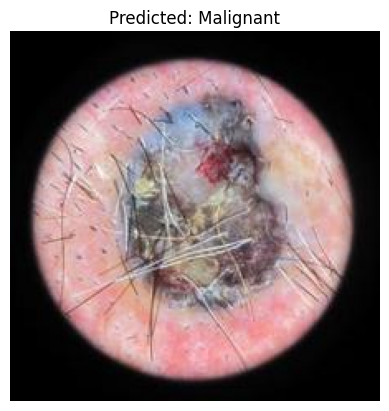

In [ ]:

# Test on new image
predict_skin_cancer("/kaggle/input/melanoma-cancer-dataset/test/Malignant/5616.jpg", model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


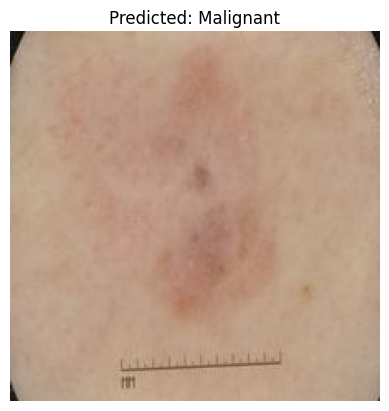

In [ ]:

# Test on new image
predict_skin_cancer("/kaggle/input/melanoma-cancer-dataset/train/Malignant/1004.jpg", model)